# Time-lapse tracer experiment in sand column
In this experiment, time-lapse ERT is used to monitor the infiltration of a tracer in a sand column.

- injection of 2000 uS/cm
- all with 40 mm/h rate
- ERT monitoring every 11.25 s

Plan of the experimental setup:

<img src="img/column-schema.jpg" width="400" height="1000">

In [1]:
 # trick to import a resipy from a local copy (you won't need that if you `pip install resipy`)
import sys 
sys.path.append('../src')

from resipy import R2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyvista as pv

datadir = '../src/examples/dc-3d-timelapse-column/'

API path =  /media/jkl/data/phd/tmp/resipy/src/resipy
ResIPy version =  2.2.3
cR2.exe found and up to date.
R3t.exe found and up to date.
cR3t.exe found and up to date.


In [49]:
df = pd.read_csv(datadir + 'ert/dfmeta20200302.csv') # using ERT monitoring every 6 minutes
fnames = df[df['status'] == 'success']['filename'].values

wd = invdir + '200302b/'
k = R2(wd, typ='R3t')
#k = R2(typ='R3t')
#k.dirname = wd
dfs = writedf(fnames, wd)
k.createTimeLapseSurvey(wd + 'data/')
ielec = k.elec[:,0].astype(int) # electrode indices used in the sequence
x = elec[ielec,:]
k.setElec(x)
#k.surveys = k.surveys[::16] # subsample survey every 3 minutes (16*11.25s)
#k.param['reg_mode'] = 1 # background constrain
k.importMesh(invdir + 'mesh/mesh3d.dat', flag_3D=True)
k.param['node_elec'] = np.c_[np.arange(len(ielec))+1, ielec+1]
k.param['num_xy_poly'] = 0
k.param['xy_poly_table'] = []
k.param['zmin'] = -10
k.param['zmax'] = 50
k.param['a_wgt'] = 0.02
#k.invert(parallel=True)
#k.getResults()

Working directory is: /home/blanchy/Documents/projects/icl/inversion/200302b
clearing the dirname
Inf or NaN: filterData: 0 / 100 quadrupoles removed.
strange quadrupoles: filterData: 0 / 100 quadrupoles removed.
40/100 reciprocal measurements NOT found.
40 measurements error > 20 %
computed DOI : -46.00
../projects/icl/data/../inversion/200302b/data/dataset001.csv imported
--------- ../projects/icl/data/../inversion/200302b/data/dataset001.csv imported
Survey.filterDefault: Number of Inf or NaN :  2
Inf or NaN: filterData: 2 / 100 quadrupoles removed.
strange quadrupoles: filterData: 0 / 98 quadrupoles removed.
40/98 reciprocal measurements NOT found.
38 measurements error > 20 %
../projects/icl/data/../inversion/200302b/data/dataset002.csv imported
--------- ../projects/icl/data/../inversion/200302b/data/dataset002.csv imported
Inf or NaN: filterData: 0 / 100 quadrupoles removed.
strange quadrupoles: filterData: 0 / 100 quadrupoles removed.
40/100 reciprocal measurements NOT found.
4

In [22]:
#k.computeDiff() # run once
for i, m in enumerate(k.meshResults):
    m.write_vtk(wd + 'out{:03d}.vtk'.format(i))

(0, 15000)

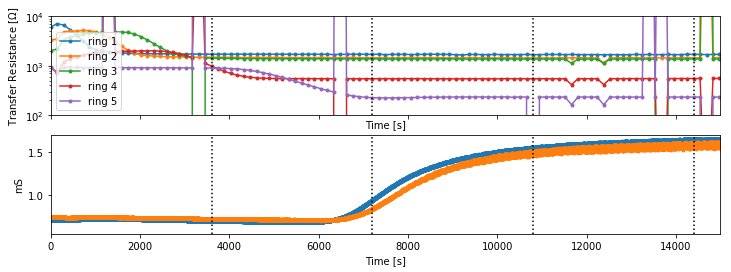

In [53]:
#k.showRMS()
steps = np.array([60, 120, 180, 240])*60
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12,4))
showEvol(k, dt=144, ax=axs[0])
axs[0].set_ylim([1e2, 1e4])
[axs[0].axvline(a, color='k', linestyle=':') for a in steps]
showOutflow(datadir + 'outflow/20030201.txt', ax=axs[1])
showOutflow(datadir + 'outflow/20030202.txt', ax=axs[1])
[axs[1].axvline(a, color='k', linestyle=':') for a in steps]
axs[1].set_ylim([0.55, 1.7])
axs[1].set_xlim([0, 15000])
#fig.savefig(outputdir + 'evolution.png')

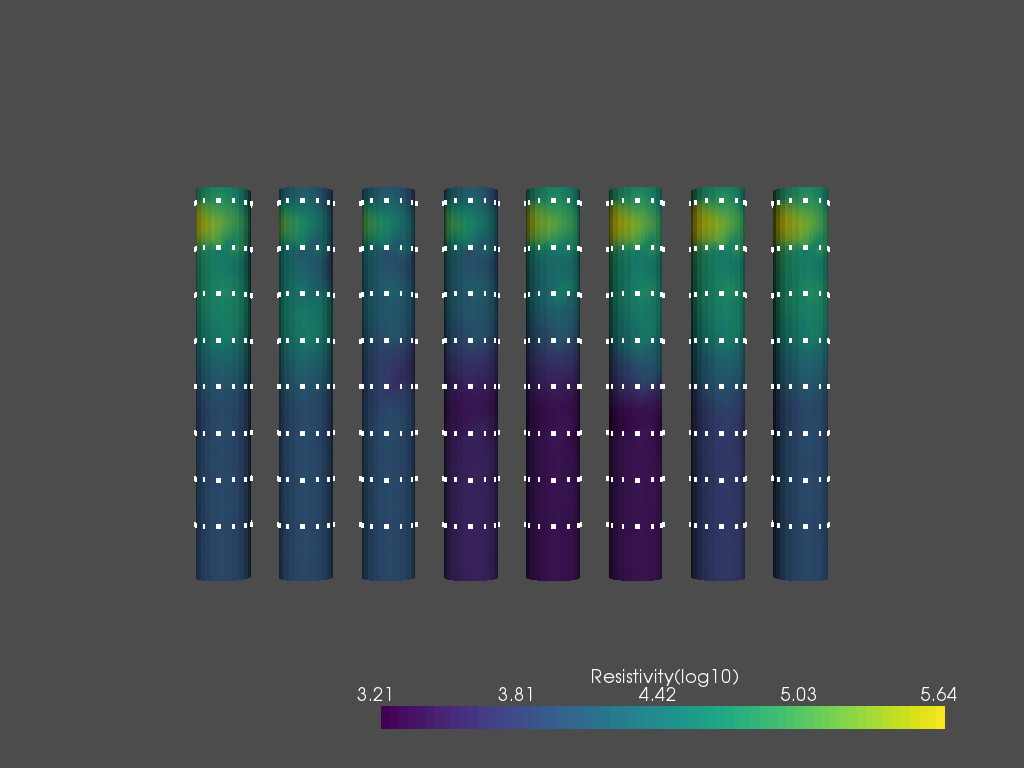

In [32]:
# graph
import pyvista as pv
p = pv.Plotter(notebook=True)
for i in np.arange(len(k.surveys))[::5]:
    mesh = pv.read(wd + 'f{:03d}.vtk'.format(i+1))
    mesh.translate([2*i, 0, 0])
    p.add_mesh(mesh, scalars='Resistivity(log10)', cmap='viridis')
    melec = pv.PolyData(elec)
    melec.translate([2*i, 0, 0])
    p.add_mesh(melec)
p.view_xz()
p.show()
# add annotation

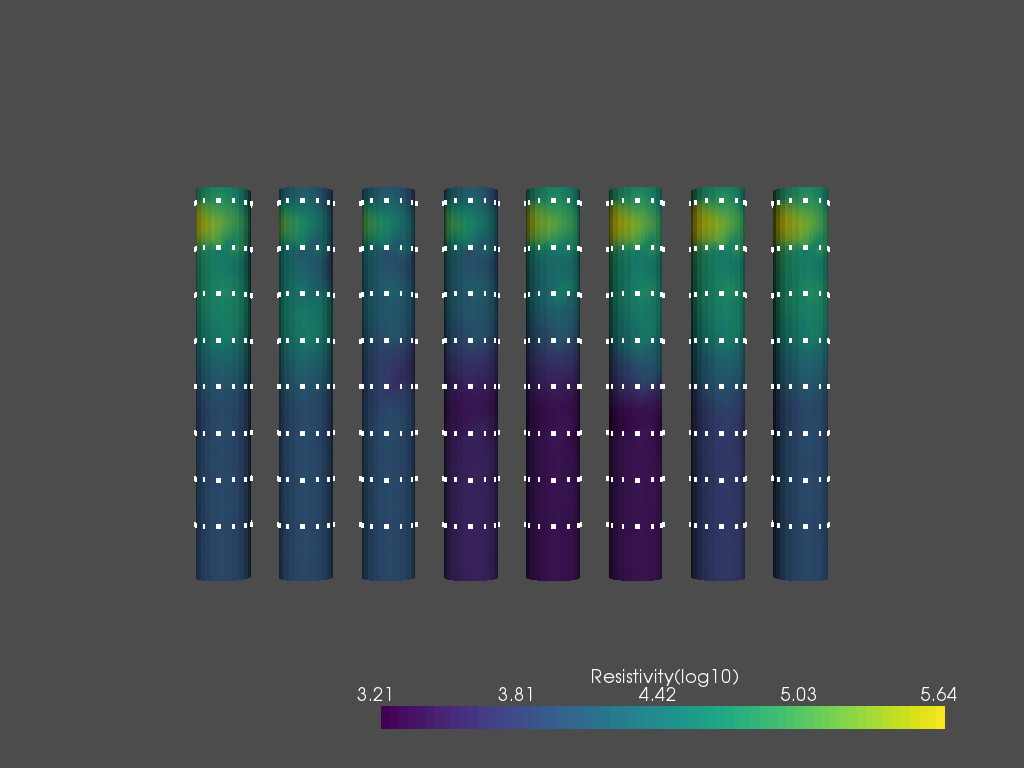

In [32]:
# graph of differences
import pyvista as pv
p = pv.Plotter(notebook=True)
for i in np.arange(len(k.surveys))[::5]:
    mesh = pv.read(wd + 'f{:03d}.vtk'.format(i+1))
    mesh.translate([2*i, 0, 0])
    p.add_mesh(mesh, scalars='Resistivity(log10)', cmap='viridis')
    melec = pv.PolyData(elec)
    melec.translate([2*i, 0, 0])
    p.add_mesh(melec)
p.view_xz()
p.show()
# add annotation

NOTE: opening all the vtk in paraview, enables to create an animated gif that shows the tracer progression in the column.

[gif]()